<a href="https://colab.research.google.com/github/n3d1m/SYDE-677-Final-Project/blob/main/NormalizationV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Imports
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
from skimage.exposure import match_histograms

In [2]:
!rm -r sample_data/
!rm -r montgomery/
!rm -r china/

!mkdir montgomery
!mkdir china

rm: cannot remove 'montgomery/': No such file or directory
rm: cannot remove 'china/': No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [12]:
def showImagesHorizontally(images_shown, image_directory, title):

    list_of_files = sorted(os.listdir(image_directory))
    if 'Thumbs.db' in list_of_files:
      list_of_files.remove('Thumbs.db')

    fig = plt.figure(figsize=(20,20))
    fig.suptitle(title,y=0.6)

    loop_range = len(list_of_files) if len(list_of_files) < images_shown else images_shown

    for i in range(loop_range):
      a=fig.add_subplot(1,images_shown,i+1)
      image_path = image_directory + list_of_files[i]
      filename, file_extension = os.path.splitext(image_path)

      if file_extension == '.tiff':
        image = tiff.imread(image_path) 
        image = np.clip(image, 0, 1)
        
      else:
        image = imread(image_path)

      plt.imshow(image,cmap='Greys_r') 
      plt.axis('off')

In [7]:
def crop_background(image_directory, is_test):

  list_of_files = os.listdir(image_directory)
  loop_range = 5 if is_test else len(list_of_files)
  

  for i in range(loop_range): 

    if(list_of_files[i] != 'Thumbs.db'): # there is a .db file at the end of each image directory that needs to be avoided
      img = cv2.imread(image_directory + list_of_files[i])
      img = cv2.normalize(img,  img, 0, 255, cv2.NORM_MINMAX) # normalize image to pixel values between 0 and 255 - needed for thresholding 
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # threshold 
      thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
      hh, ww = thresh.shape

      # make bottom 2 rows black where they are white the full width of the image
      thresh[hh-3:hh, 0:ww] = 0

      # get bounds of white pixels
      white = np.where(thresh==255)
      xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])

      # crop the image at the bounds adding back the two blackened rows at the bottom
      crop = img[ymin:ymax+3, xmin:xmax]

      image_size = (1024,1024)
      final_crop = cv2.resize(crop, dsize=image_size, interpolation=cv2.INTER_CUBIC)

      # save resulting masked image
      if 'CHNCXR' in list_of_files[i]:
        cv2.imwrite('/content/china/' + list_of_files[i], final_crop)
      else:
        cv2.imwrite('/content/montgomery/' + list_of_files[i], final_crop)

      

In [8]:
drive_directory = '/content/drive/MyDrive/SYDE 677 Final Project/CXR_png/'
crop_background(drive_directory, False)

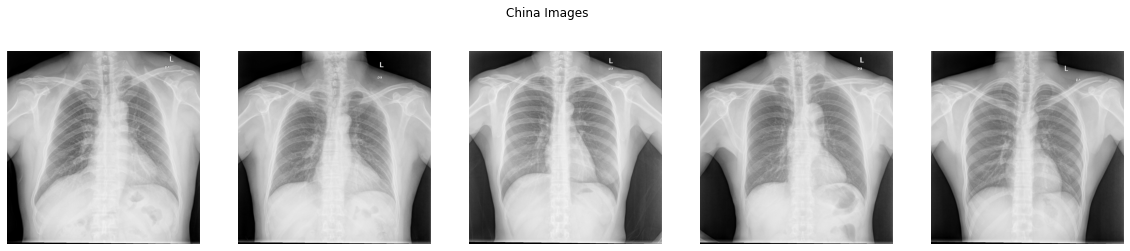

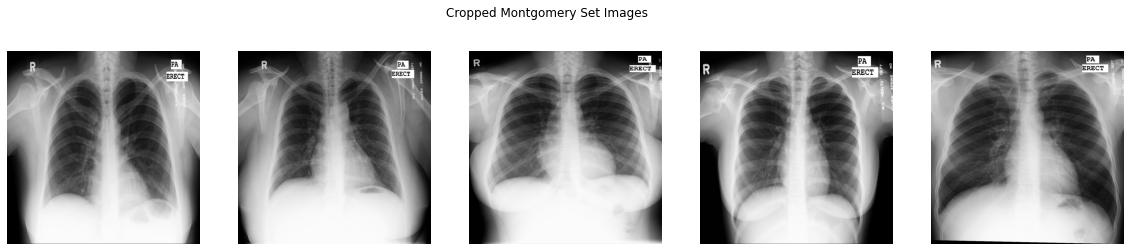

In [13]:
showImagesHorizontally(5,'/content/china/', 'China Images')
showImagesHorizontally(5, '/content/montgomery/', 'Cropped Montgomery Set Images')

True

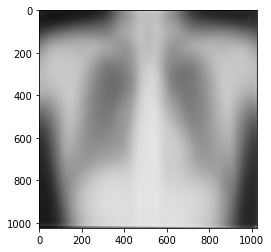

In [19]:
#average image generation

reference_images = os.listdir('/content/china/')

w,h = Image.open('/content/china/' + reference_images[0]).size
N = len(reference_images)

# Create a numpy array of floats to store the average (assume RGB images)
arr=np.zeros((h,w,3),np.float)

# Build up average pixel intensities, casting each image as an array of floats
for im in reference_images:
    imarr=np.array(Image.open('/content/china/' + im),dtype=np.float)
    arr=arr+imarr/N

# Round values in array and cast as 8-bit integer
arr=np.array(np.round(arr),dtype=np.uint8)

plt.imshow(arr)

# Generate, save and preview final image
cv2.imwrite('Average.png', arr)

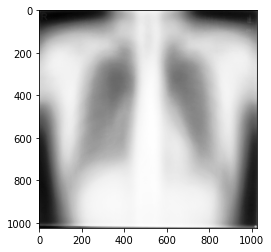

In [46]:
clahe = cv2.createCLAHE(clipLimit = 1)
convert_matched = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
image_clahe = clahe.apply(convert_matched)
cv2.imwrite('Average_CLAHE.png', arr)

plt.imshow(image_clahe,cmap='Greys_r')

In [47]:
!rm -r montgomery_match/
!mkdir montgomery_match

In [48]:
def histogram_matching(image_path):

  list_of_files = os.listdir(image_path)
  average_image = cv2.imread('Average_CLAHE.png')

  for im in list_of_files:

    current_image = cv2.imread(image_path + im)
    matched = match_histograms(current_image, average_image, multichannel=True)

    clahe = cv2.createCLAHE(clipLimit = 1)
    convert_matched = cv2.cvtColor(matched, cv2.COLOR_BGR2GRAY)
    image_clahe = clahe.apply(convert_matched)

    cv2.imwrite('/content/montgomery_match/' + im, image_clahe)


  

In [49]:
histogram_matching('/content/montgomery/')

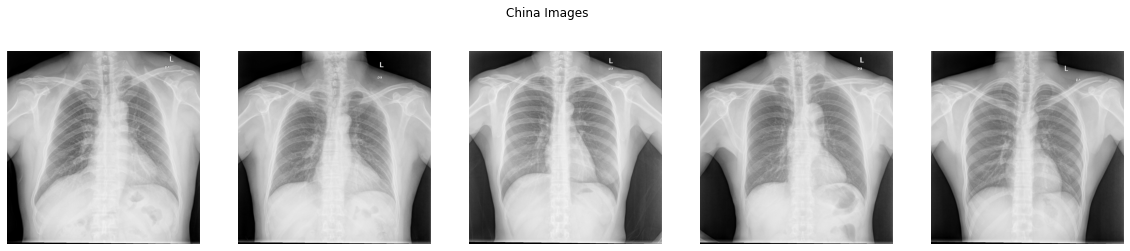

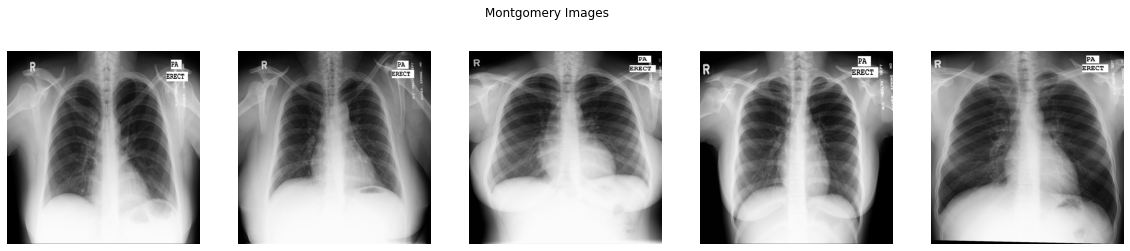

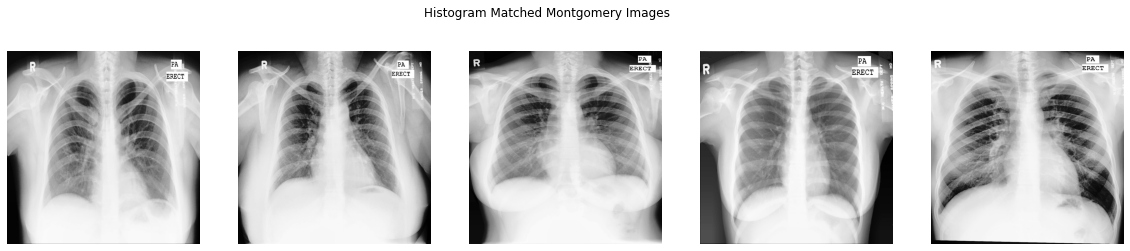

In [50]:
showImagesHorizontally(5,'/content/china/', 'China Images')
showImagesHorizontally(5, '/content/montgomery/', 'Montgomery Images')
showImagesHorizontally(5, '/content/montgomery_match/', 'Histogram Matched Montgomery Images')

In [54]:
# Comparing histograms

def histogram_comparison(path_1, path_2, method):

  image_list_1 = os.listdir(path_1)
  image_list_2 = os.listdir(path_2)

  histogram_values = []

  for i in range(len(image_list_1)):

    current_reference_image = cv2.imread(path_1 + image_list_1[i])
    current_hist = cv2.calcHist([current_reference_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    current_hist = cv2.normalize(current_hist, current_hist).flatten()

    for j in range(10):
      current_comparison_image = cv2.imread(path_2 + image_list_2[j])
      reference_hist = cv2.calcHist([current_comparison_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
      reference_hist = cv2.normalize(reference_hist, reference_hist).flatten()

      hist_comparison = cv2.compareHist(current_hist, reference_hist, method)
      histogram_values.append(hist_comparison)

  return histogram_values



In [55]:
OPENCV_METHODS = (
	("Correlation", cv2.HISTCMP_CORREL), # larger value = more similarity
	("Chi-Squared", cv2.HISTCMP_CHISQR), # smaller value = more similarity
	("Intersection", cv2.HISTCMP_INTERSECT), # larger value = more similarity
	("Hellinger", cv2.HISTCMP_BHATTACHARYYA)) # smaller value = more similarity

for (methodName, method) in OPENCV_METHODS:

  final_histogram_values = histogram_comparison('/content/montgomery/', '/content/china/', method)
  print(methodName, np.mean(final_histogram_values), np.std(final_histogram_values))


Correlation 0.7497753932243231 0.09448275588814027
Chi-Squared 1.4909978449107373 0.7442472672895594
Intersection 1.676463351190846 0.25243950627552875
Hellinger 0.3000971447778905 0.0666584012422597


In [56]:
for (methodName, method) in OPENCV_METHODS:

  final_histogram_values = histogram_comparison('/content/montgomery_match/', '/content/china/', method)
  print(methodName, np.mean(final_histogram_values), np.std(final_histogram_values))

Correlation 0.9156689128583411 0.044891370999301926
Chi-Squared 63.85335153445272 987.7427756656602
Intersection 1.8594488751343095 0.1885688457170848
Hellinger 0.20189916661137805 0.06307217109046287
